# <center><b>川渝地区新中式茶饮消费现状与意愿调查</b></center>

## 提前导入库

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib
import warnings

from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier


# 忽略无关警告
warnings.filterwarnings('ignore')

# 图像可以显示中文
matplotlib.rcParams['font.sans-serif'] = ['STsong']
matplotlib.rcParams['axes.unicode_minus'] = False

# 设置，使得数据对齐
pd.set_option('display.max_rows', None)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)

# 设置随机种子
np.random.seed(114514)

## 1. 数据读取与探索性分析

In [2]:
raw_data = pd.read_excel('resources/当代大学生对于新中式茶饮消费需求调研及新店开业营销探究.xlsx') # 原始数据
raw_data = raw_data.iloc[:,1:-2] # 去掉第一行的数据
raw_data.drop(raw_data.columns[19:22], axis=1, inplace=True)

raw_data.info() # 查看数据结构

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   1、您的性别：                     666 non-null    object
 1   2、您的年级                      666 non-null    object
 2   3、在校期间，您的月消费一般为：            666 non-null    object
 3   4、您一个月喝茶饮的频率是？              666 non-null    object
 4   5、您习惯的茶饮购买渠道是？              666 non-null    object
 5   6、平常生活中，您习惯于从以下哪种渠道中获取的信息？  666 non-null    object
 6   7、您希望以哪种形式享用茶饮？             666 non-null    object
 7   8、以下茶饮分类中，目前您更偏向于喝哪种？       666 non-null    object
 8   9、您更喜欢哪种口味的茶饮？              666 non-null    object
 9   10、您对茶饮的甜度偏好是？              666 non-null    object
 10  11、您喜欢的包装风格是                666 non-null    object
 11  12、您最喜欢的茶饮促销方式是？            666 non-null    object
 12  13、您能接受的一杯新中式茶饮的最高价格是？      666 non-null    object
 13  14、您喝过新中式茶饮吗？               666 non-null    object

这个数据集是完整的，没有缺失值，包含了105条记录和49个整数类型的特征，现在可以进行后续的数据分析或机器学习处理。

In [3]:
# 提取量表数据
tableData: pd.DataFrame = raw_data.iloc[:,14:46]   
tableData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   15、您对新中式茶饮的认知程度是—价格区间  666 non-null    int64
 1   15、健康养生程度              666 non-null    int64
 2   15、包装风格                666 non-null    int64
 3   15、产品类型                666 non-null    int64
 4   15、围炉煮茶                666 non-null    int64
 5   19、产品质量—口味口感           666 non-null    int64
 6   19、用料品质                666 non-null    int64
 7   19、原料健康程度              666 non-null    int64
 8   19、特色度                 666 non-null    int64
 9   20、附属产品—包装精美           666 non-null    int64
 10  20、容器质量                666 non-null    int64
 11  20、赠品迷人                666 non-null    int64
 12  21、价格因素—价格合理           666 non-null    int64
 13  21、促销力度                666 non-null    int64
 14  21、性价比高                666 non-null    int64
 15  22、服务—店员服务态度           666 non-null    i

## 2. 信效度检验

In [4]:
# 信度检验------计算Cronbach's 系数
result = pg.cronbach_alpha(data=tableData)
print(result)

(0.9498505770440465, array([0.944, 0.955]))


由此计算结果得出结论，Cronbach's 系数的值为0.950，该结果可以说明该问卷是可信的或具有可靠性的

In [5]:
# 效度检验------Barlett's球形检验
chi_square_value, p_value = calculate_bartlett_sphericity(tableData)
print("bartlett球形检验参数：\n卡方值为：%f，p值为：%e"%(chi_square_value, p_value))

# 效度检验------KMO
kmo_all, kmo_model = calculate_kmo(tableData)
print("KMO检验参数：\n", kmo_model)


bartlett球形检验参数：
卡方值为：8458.090682，p值为：0.000000e+00
KMO检验参数：
 0.9786553064731399


bartlett球形检验的p值小于0.05，检验通过，说明原变量之间存在相关性，另外KMO统计量为0.979，变量相关性很强

## 3. K-means 聚类分析

In [6]:
drinked_data = pd.read_excel("resources/喝过.xlsx")
drinked_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   1、您的性别：                     396 non-null    object 
 1   2、您的年级                      396 non-null    object 
 2   3、在校期间，您的月消费一般为：            396 non-null    object 
 3   4、您一个月喝茶饮的频率是？              396 non-null    object 
 4   5、您习惯的茶饮购买渠道是？              396 non-null    object 
 5   6、平常生活中，您习惯于从以下哪种渠道中获取的信息？  396 non-null    object 
 6   7、您希望以哪种形式享用茶饮？             396 non-null    object 
 7   8、以下茶饮分类中，目前您更偏向于喝哪种？       396 non-null    object 
 8   9、您更喜欢哪种口味的茶饮？              396 non-null    object 
 9   10、您对茶饮的甜度偏好是？              396 non-null    object 
 10  11、您喜欢的包装风格是                396 non-null    object 
 11  12、您最喜欢的茶饮促销方式是？            396 non-null    object 
 12  13、您能接受的一杯新中式茶饮的最高价格是？      396 non-null    object 
 13  14、您喝过新中式茶饮吗？               396 non

In [7]:
WCSS = [] # 簇内平方和
X = drinked_data.iloc[:, :-1] # 不包括最后一列的所有数据
X = pd.get_dummies(X, drop_first=True, dtype=int)
for i in range(2, 11): # 从2到10中选择
    km = KMeans(n_clusters=i, n_init='auto', random_state=0, algorithm='elkan').fit(X)
    WCSS.append(km.inertia_) # inertia_: 簇内平方和

WCSS

[4808.255499841723,
 4633.004016389953,
 4570.06055927418,
 4482.361843862682,
 4429.769970556167,
 4399.673241144033,
 4355.205484817816,
 4346.483327833691,
 4310.778459943044]

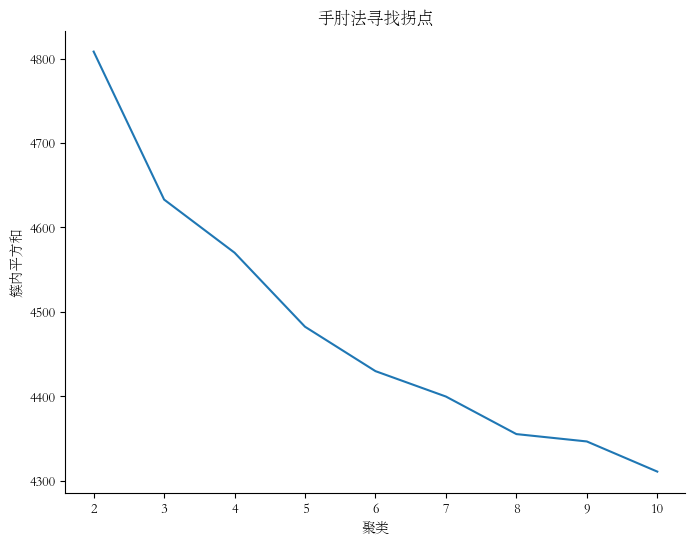

In [8]:
x_idx = np.arange(2, 11)
Y = np.array(WCSS)
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(x_idx, Y)
ax.set_title('手肘法寻找拐点')
ax.set_xlabel('聚类')
ax.set_ylabel('簇内平方和')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


根据K-means聚类分析的结果，受众人群分为3类较为合适

查看每一类的数量

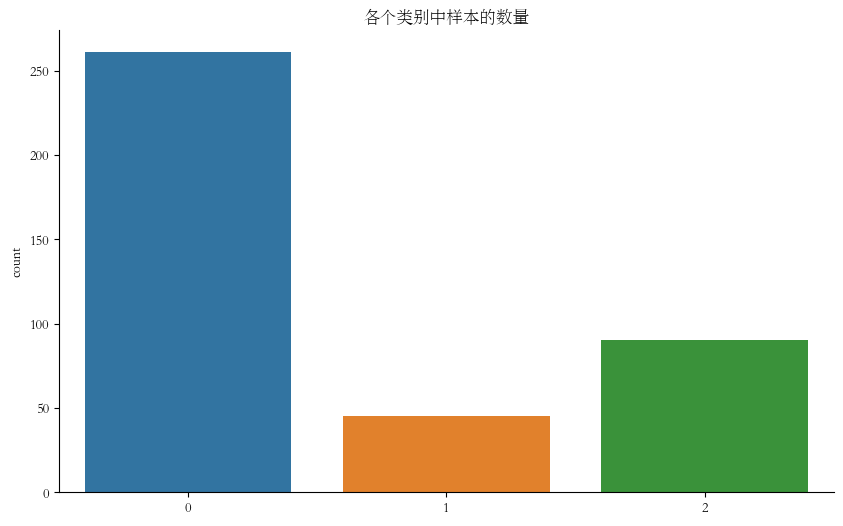

In [9]:
model = KMeans(n_clusters=3, n_init='auto', random_state=0, algorithm='elkan').fit(X)

fig, ax = plt.subplots(figsize=(10,6))
pl = sns.countplot(x = model.labels_)
pl.set_title("各个类别中样本的数量")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

(To:LXY 描述一下各个类别的数量就好了)

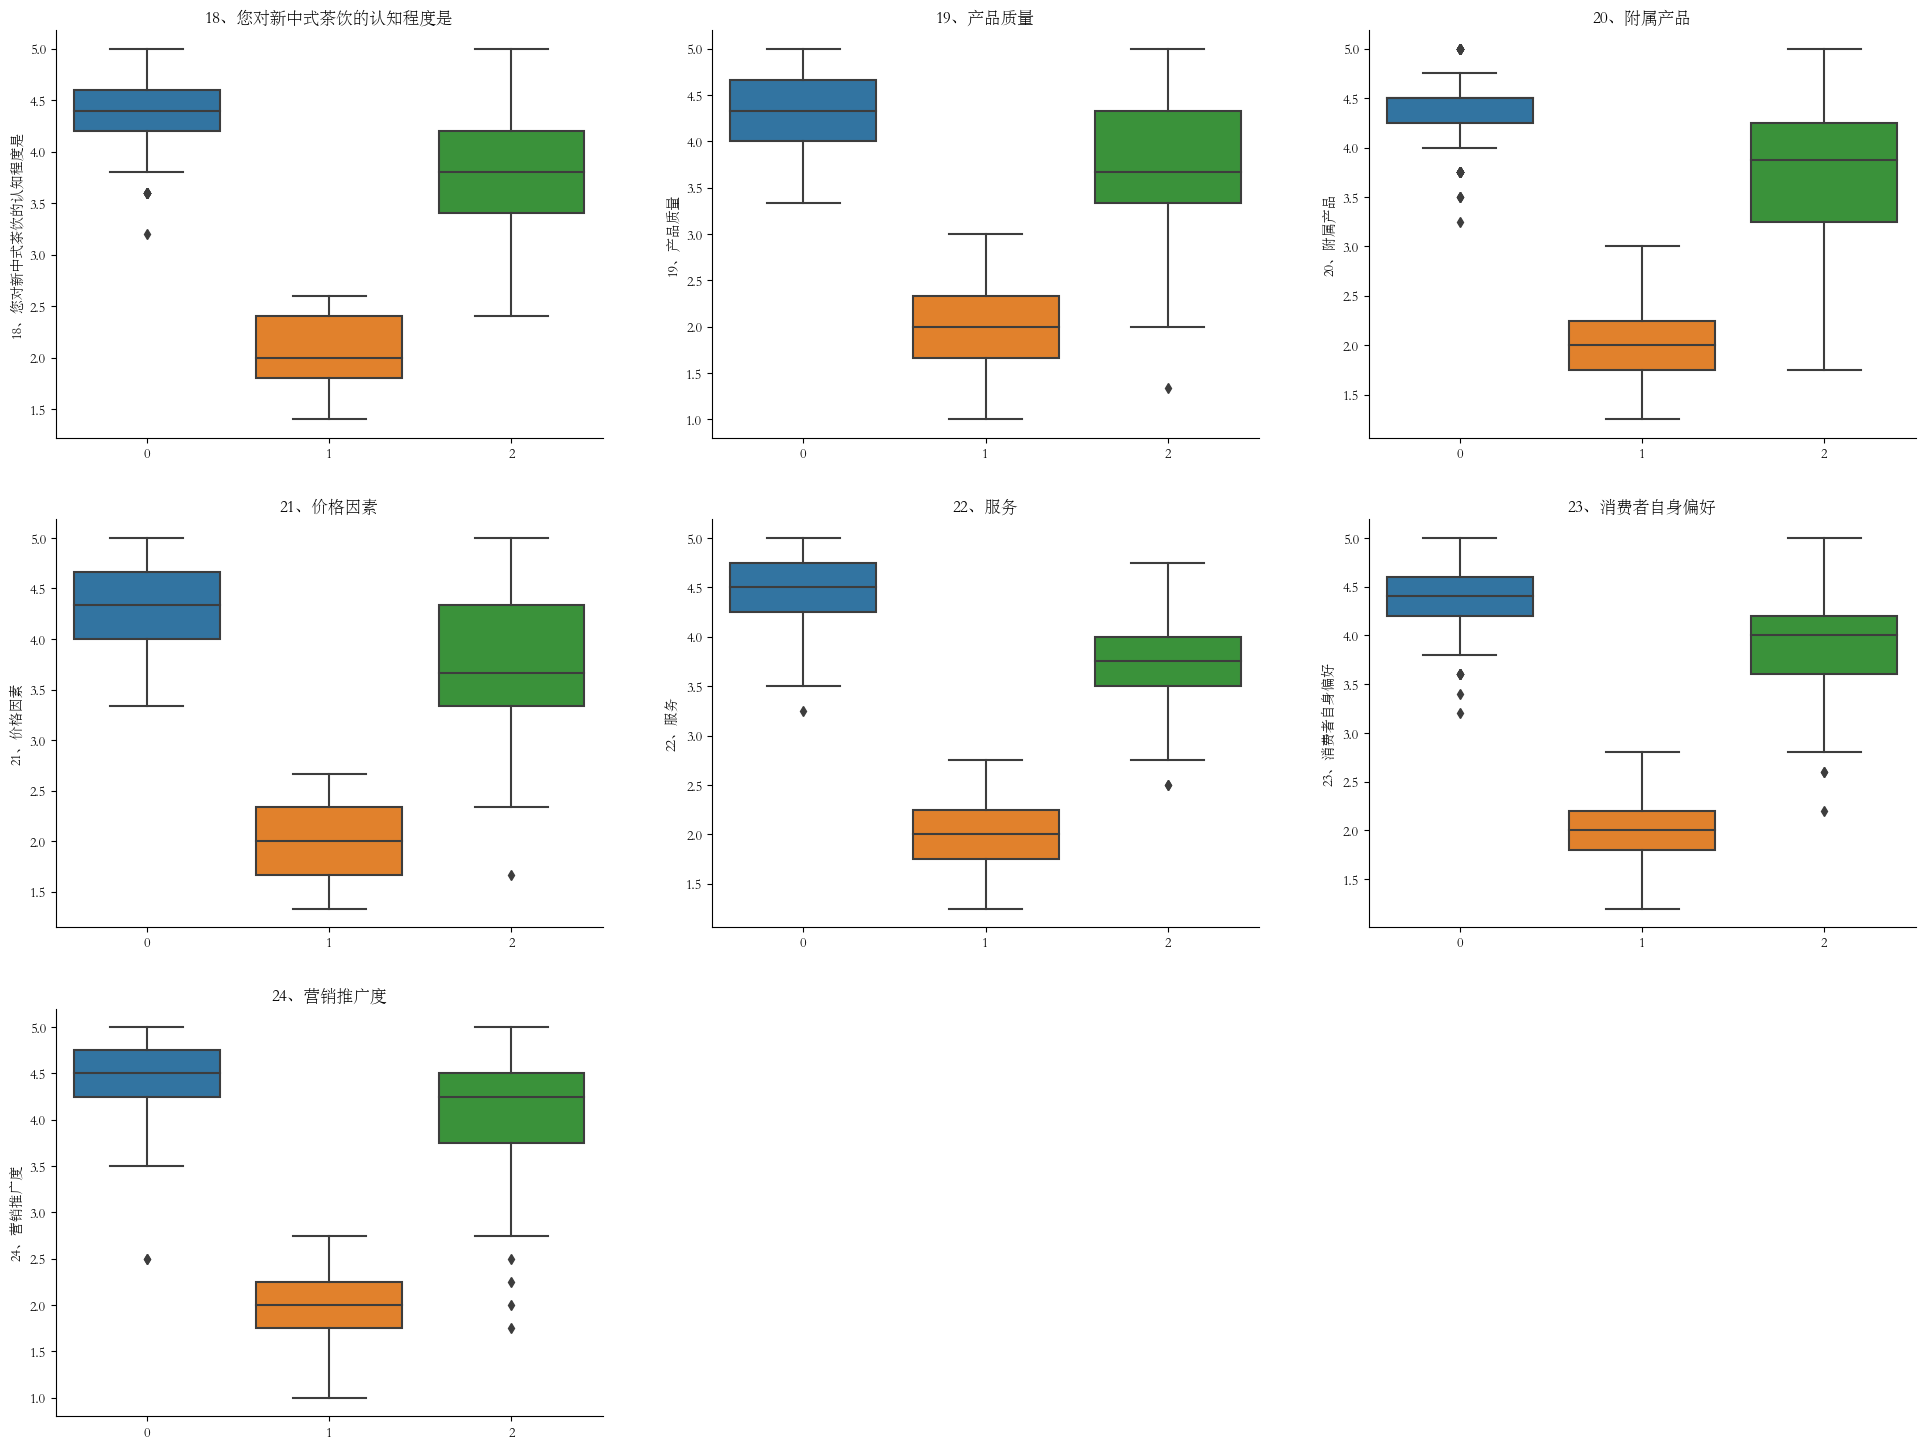

In [10]:
col_names = [
    '18、您对新中式茶饮的认知程度是',
    '19、产品质量', 
    '20、附属产品', 
    '21、价格因素', 
    '22、服务',
    '23、消费者自身偏好', 
    '24、营销推广度'
]

plt.figure(figsize=(24, 18))
for i, col in enumerate(col_names):
    plt.subplot(3, 3, i+1)
    pi = sns.boxplot(x = model.labels_, y = col, data = drinked_data)
    pi.set_title(col, fontdict={"fontsize":12})
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
plt.show()


(To:LXY 根据箱线图进行描述就能知道具体哪几类了)
> 例如：
> - 类0：进行的购买金额低，频率高，一次性最大金额低，余额较低，预借现金支付频率低，一次性购买频率低
> - 类1：进行的购买金额较低，频率高，一次性最大金额低，余额较低，预借现金支付频率低，一次性购买频率高
> - 类2：进行的购买金额高，频率高，一次性最大金额高，余额中等，预借现金支付频率低，一次性购买频率高
> - 类3：进行购买的金额低，一次性最大金额低，余额低，预计现金支付频率低，一次性购买频率低
> - 类4：进行购买的金额低，一次性最大金额低，余额高，预计现金支付频率低，一次性购买频率高
> - 类5：进行购买的金额低，一次性最大金额低，余额中等，预计现金支付频率低，一次性购买频率低
> - 等……（这是一般描述聚类分析结果的形式，并不是我们这个项目的结果，你要自己写一下）



## 4.决策树与随机森林

In [11]:
# 获取目标值
X = pd.get_dummies(drinked_data.iloc[:, :-1], drop_first=True, dtype=int)
Y = drinked_data.iloc[:, -1].values

for i in range(len(Y)):
    if Y[i] > 3:
        Y[i] = 1
    else:
        Y[i] = 0
y = Y.astype(int)
print(X)
print(y)

     18、您对新中式茶饮的认知程度是  19、产品质量  20、附属产品  21、价格因素  \
0                               4.2      4.000000          4.50      4.333333   
1                               3.6      2.000000          3.75      3.666667   
2                               3.2      3.333333          4.50      4.000000   
3                               4.6      4.333333          4.75      5.000000   
4                               4.0      4.000000          3.75      3.000000   
5                               4.0      4.666667          3.75      2.666667   
6                               3.6      5.000000          4.75      3.666667   
7                               2.4      3.333333          3.50      3.666667   
8                               4.6      4.333333          4.00      3.000000   
9                               3.6      4.333333          4.50      4.333333   
10                              4.6      4.000000          4.50      4.333333   
11                              4.6      4.000000        

In [12]:
# 划分测试集和训练集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 4.1.决策树

In [13]:
clf_prune = DecisionTreeClassifier()
clf_prune.fit(X_train, y_train)

DecisionTreeClassifier()

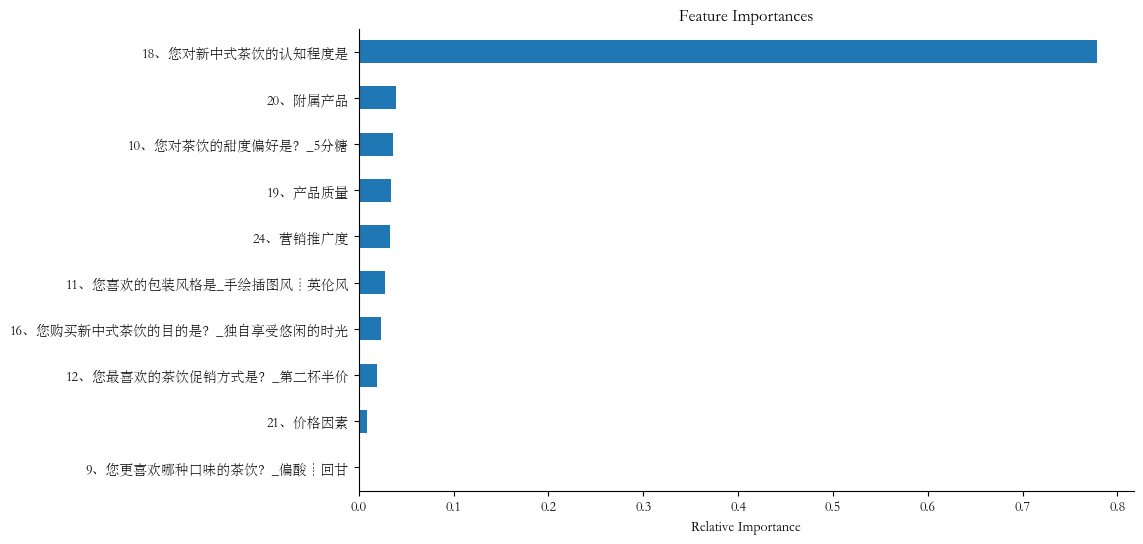

In [14]:
importances = clf_prune.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
weights.sort_values()[-10:].plot(kind = 'barh')
plt.xlabel('Relative Importance')
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

(To LXY):特征重要性可以看出哪些特征对于结果很重要，以及有多重要，描不描述无所谓

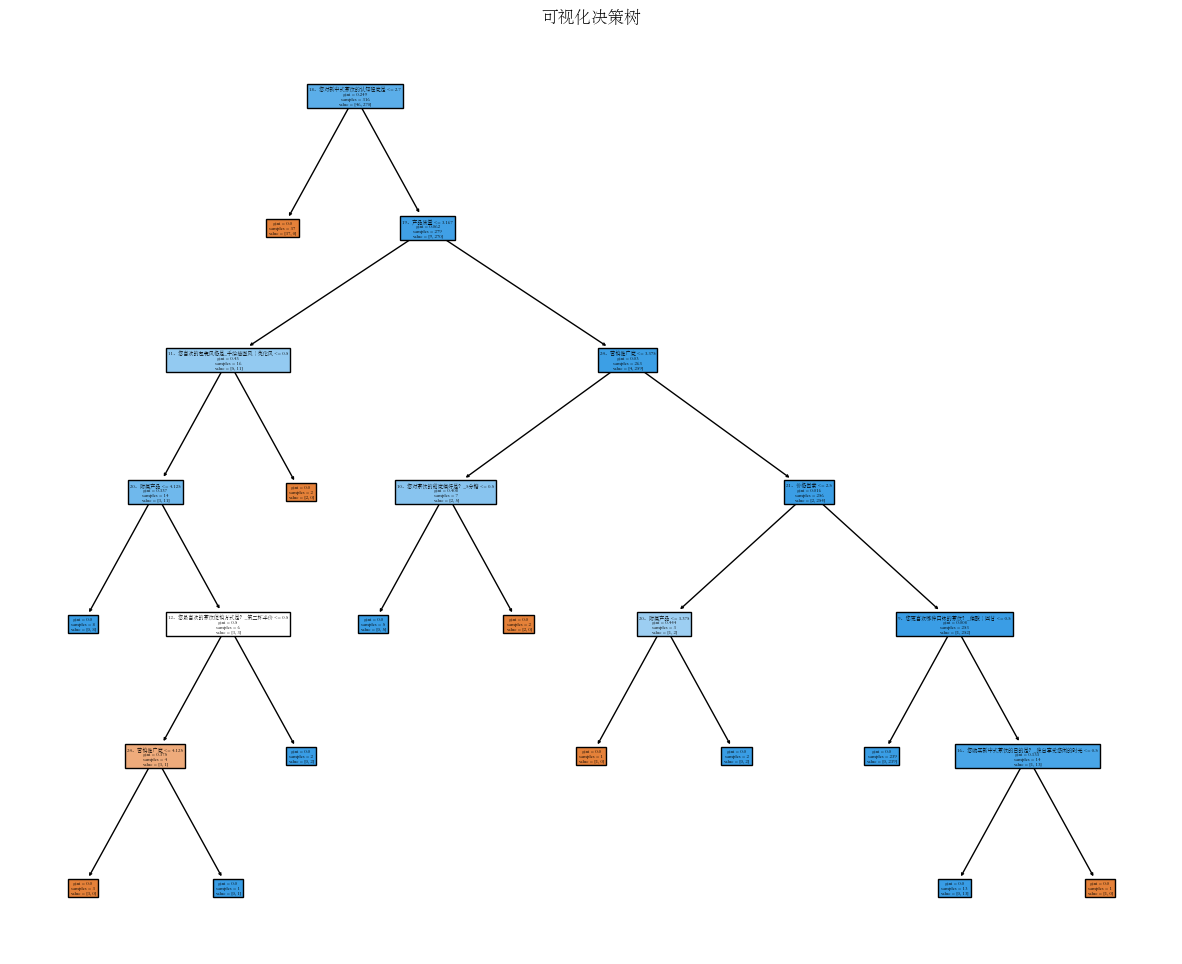

In [15]:
plt.figure(figsize = [15,12])
feature_name = list(X_train.columns)
plot_tree(clf_prune, filled=True, feature_names = feature_name, class_names = None)
plt.title("可视化决策树")
plt.show()

看看得了不用说啥

In [16]:
# 在测试集上进行预测，并计算相关指标
y_pred = clf_prune.predict(X_test)
y_pred_prob = clf_prune.predict_proba(X_test)

# 正确率
test_accuracy = clf_prune.score(X_test, y_test)
print("Accuracy=%.3f"%test_accuracy)
# 精确率
test_precision = precision_score(y_test, y_pred, average = 'micro')
print("Precision=%.3f"%test_precision)
# 召回率
test_recall = recall_score(y_test, y_pred, average = 'micro')
print("Recall=%.3f"%test_recall)
# F1值
test_f1 = f1_score(y_test, y_pred, average = 'micro')
print("test_f1=%.3f"%test_f1)

Accuracy=0.925
Precision=0.925
Recall=0.925
test_f1=0.925


混淆矩阵:
 [[ 9  2]
 [ 4 65]]


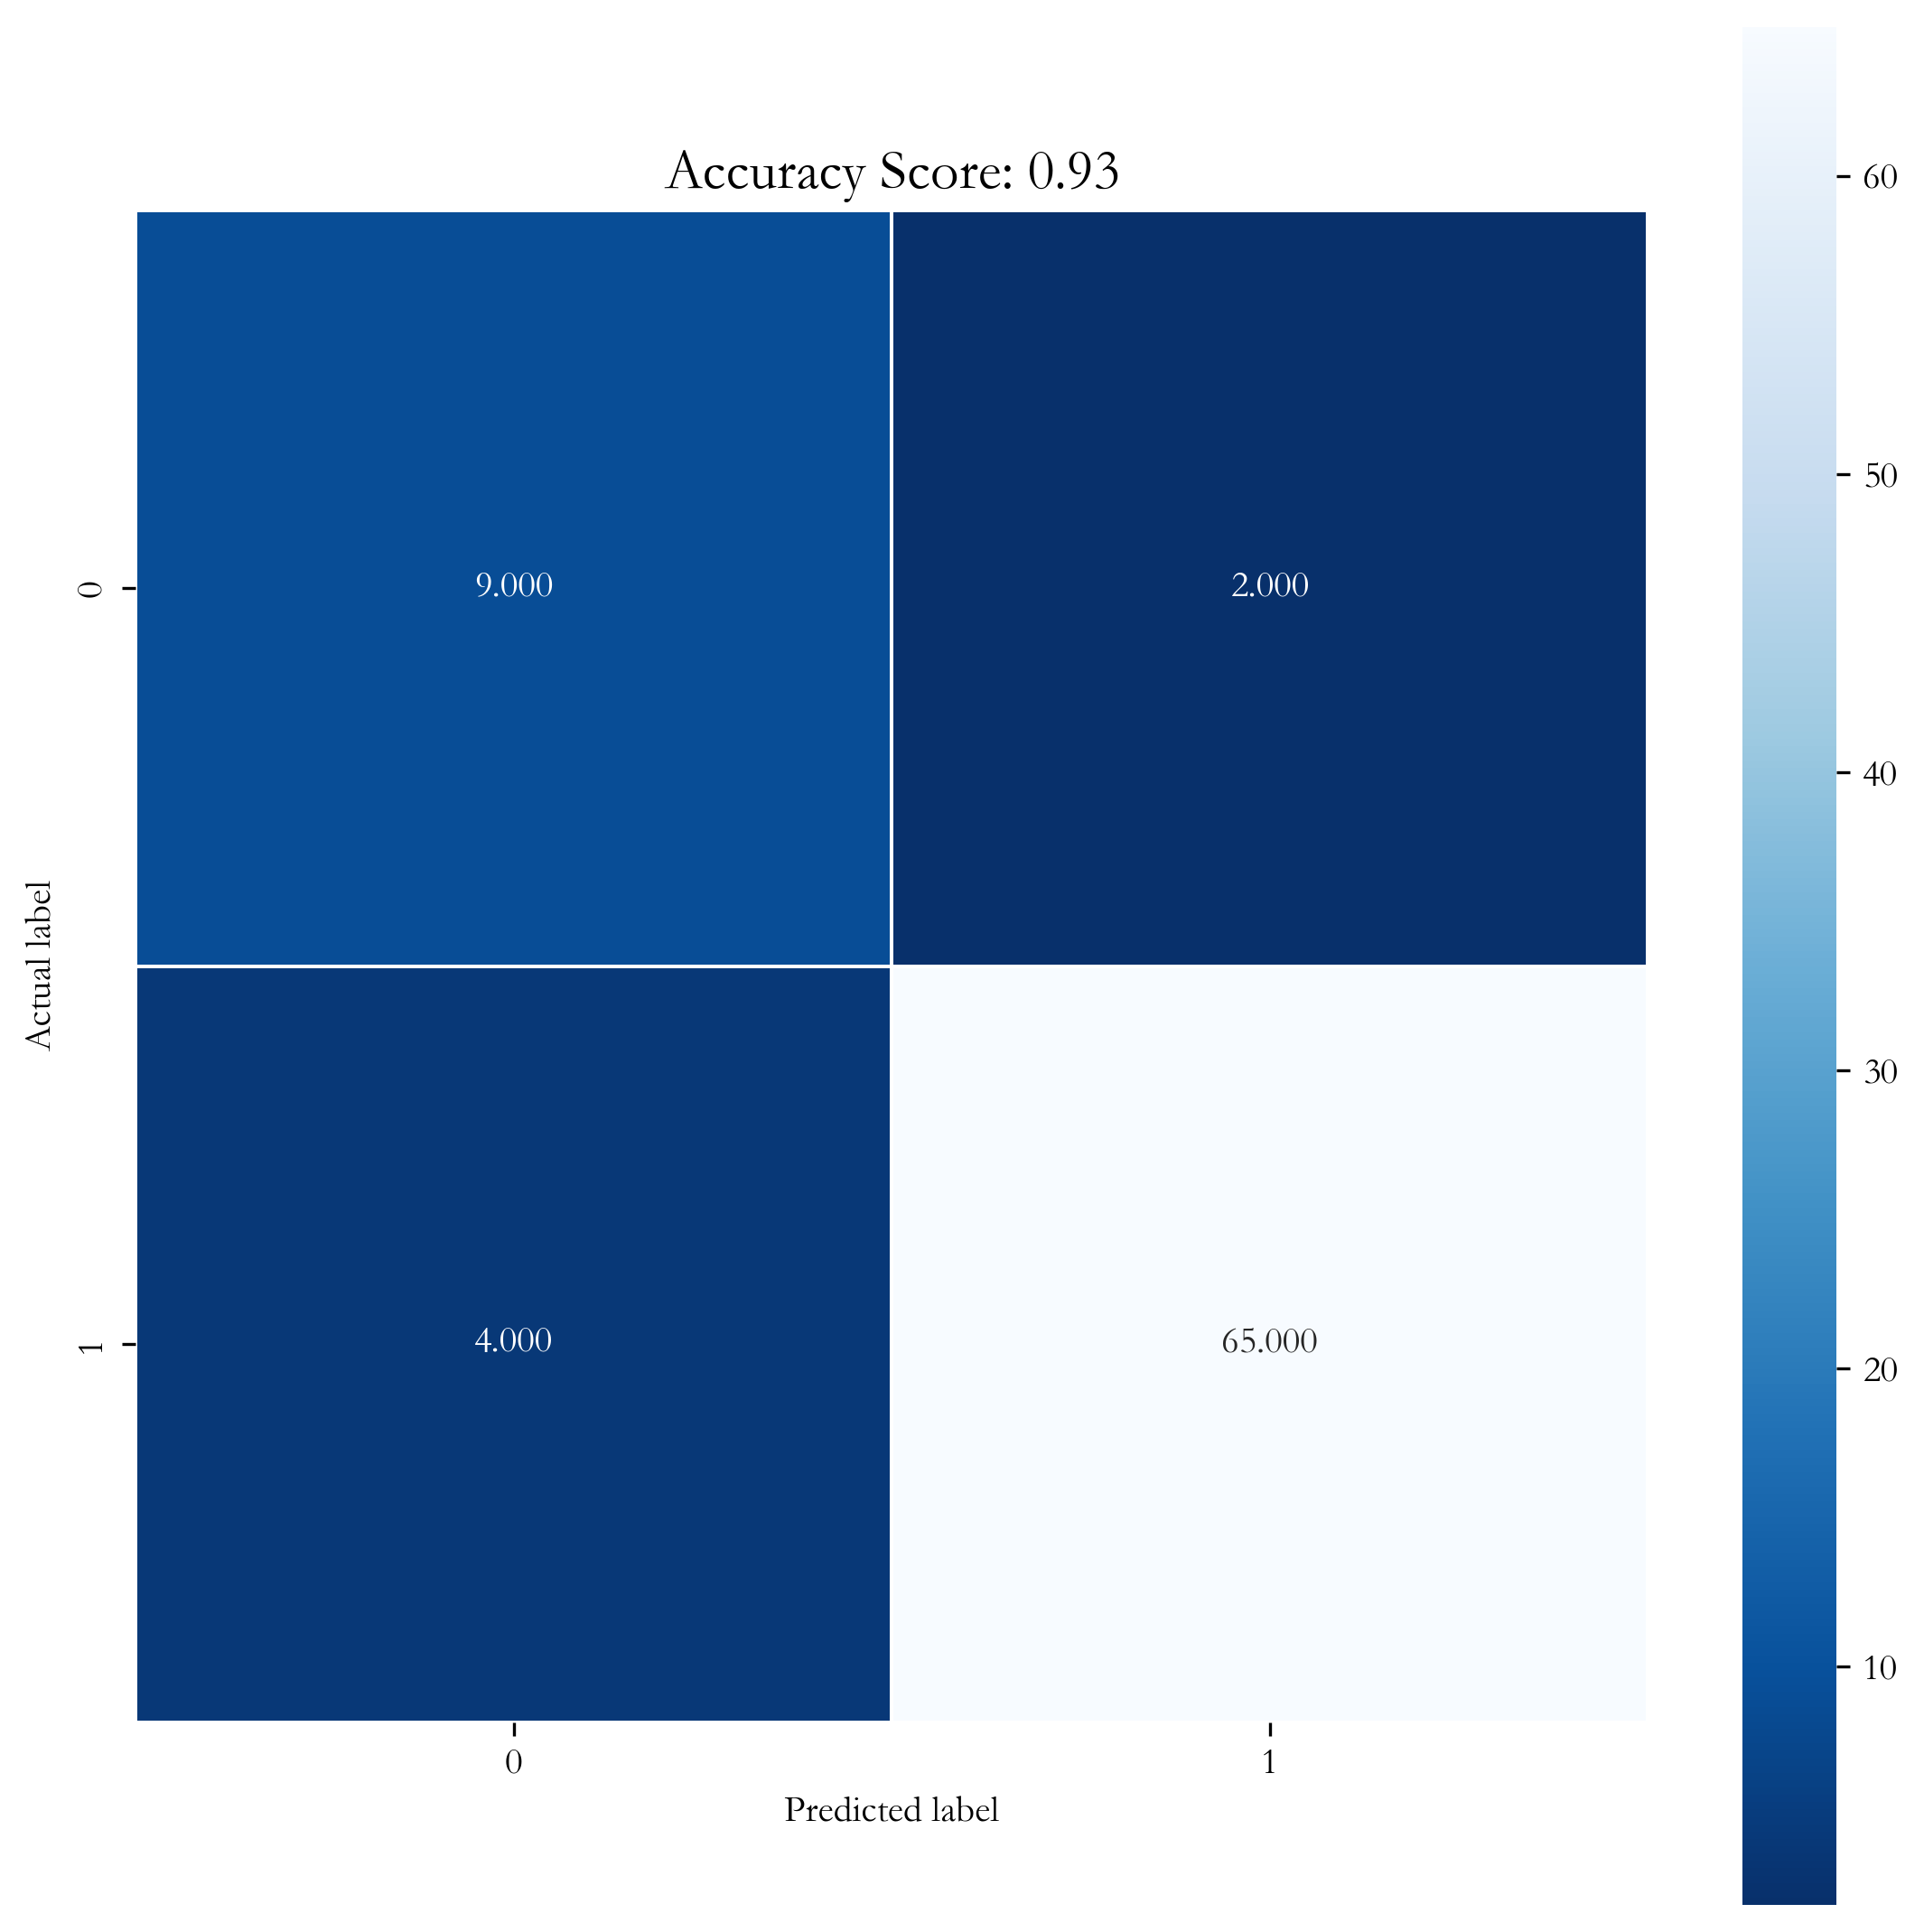

In [17]:
from utils.Display_Plot import plot_confusion_matrix

plot_confusion_matrix(y_test, y_pred, accuracy=test_accuracy, 
                      is_save=False, save_path="A")

(To LXY):混淆矩阵，这些评估用的图不要改中文，都是术语翻译会丢失原始含义，简单描述一下图就行了

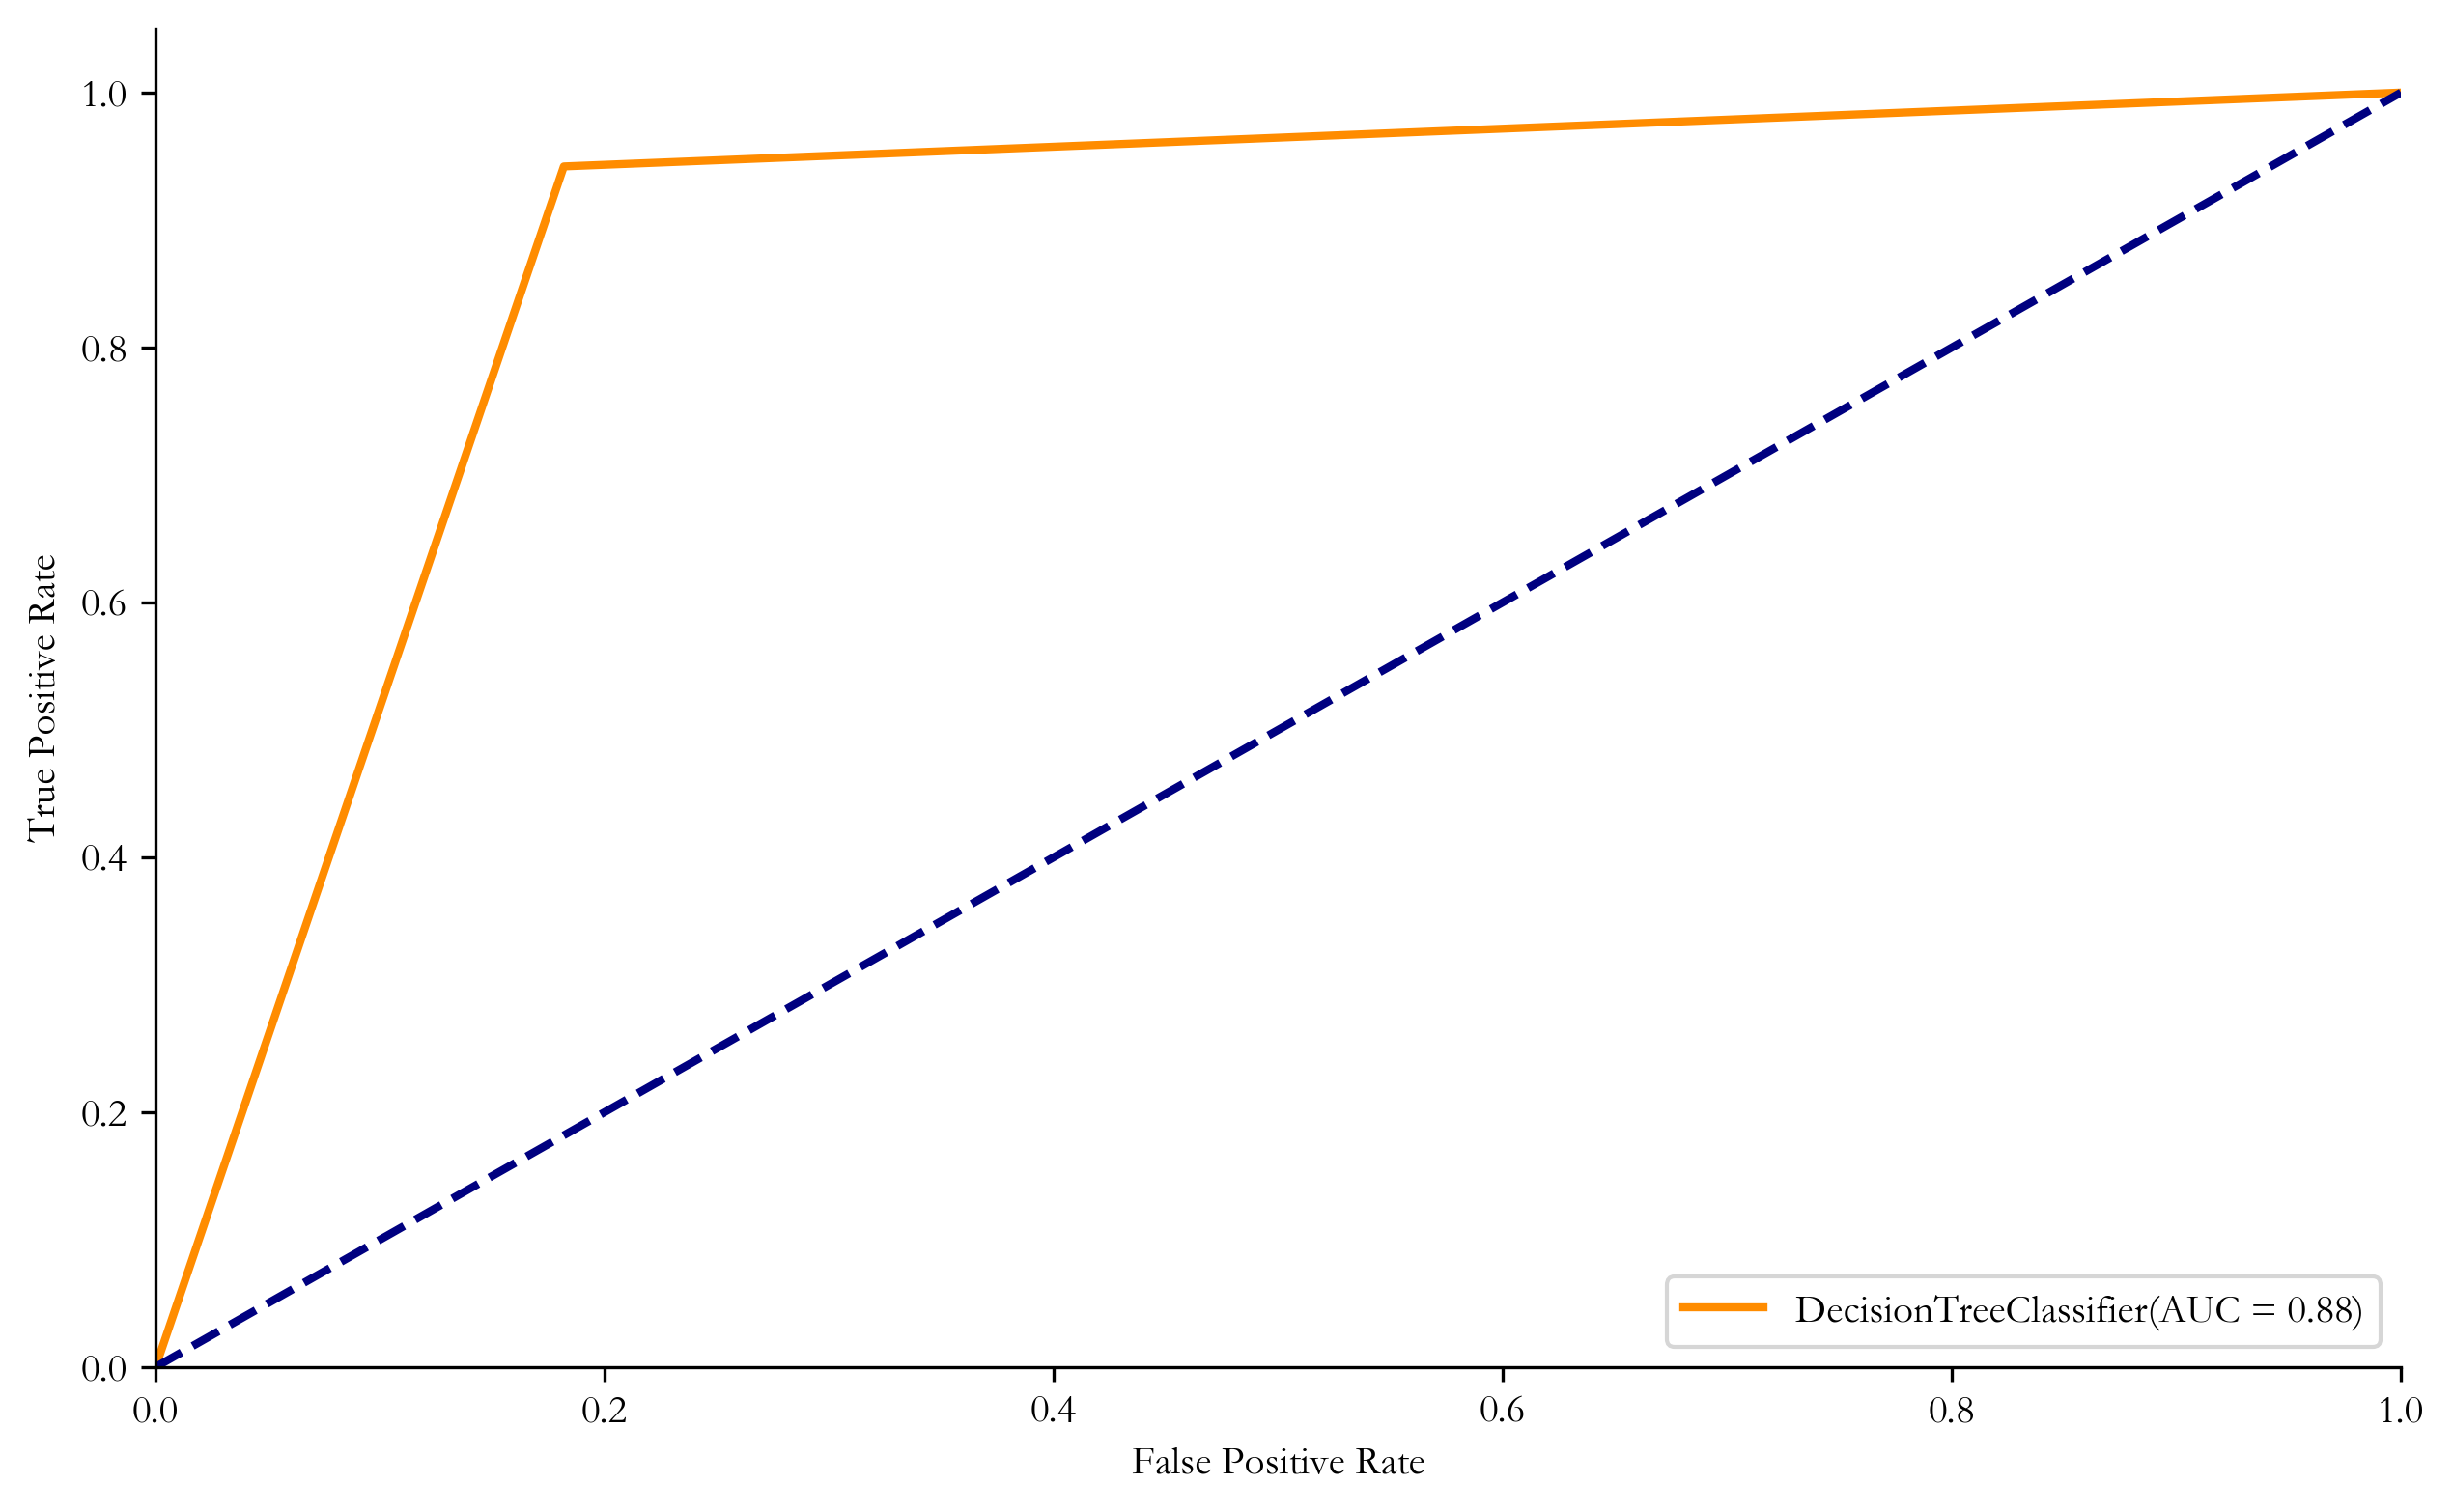

In [18]:
from utils.Display_Plot import plot_roc_curve

plot_roc_curve(y_test, y_pred_prob[::,1], "DecisionTreeClassifier", 
               is_save=False, save_path="a")

(To LXY):AUC是曲线下的面积，越大越好，简单描述一下图就行了

### 4.2.随机森林

In [19]:
model_rf = RandomForestClassifier(n_estimators=100 , oob_score = True, 
                                  random_state =50, max_features = "sqrt")

# 在训练集上训练
model_rf.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=50)

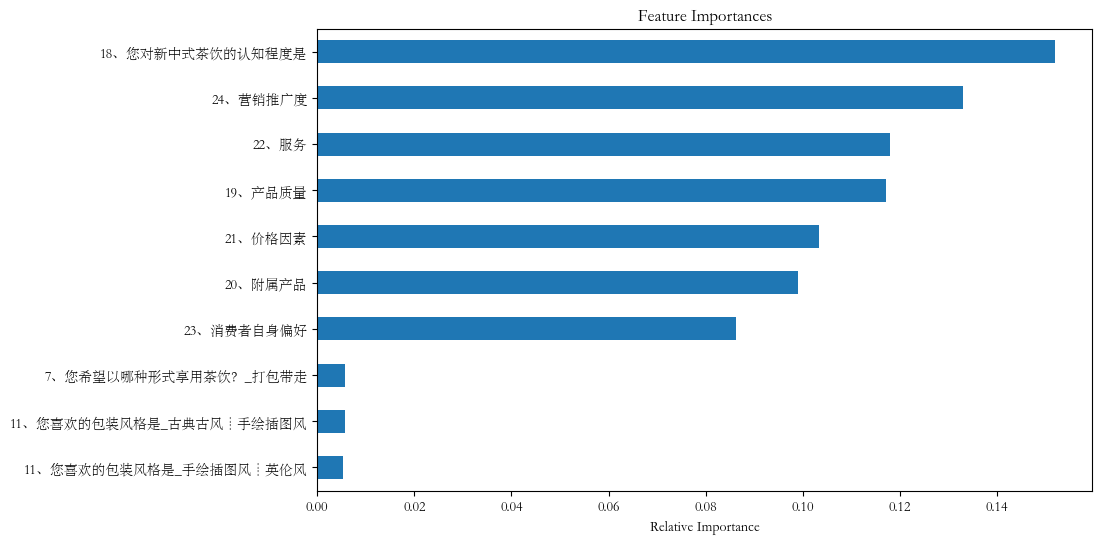

In [20]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
weights.sort_values()[-10:].plot(kind = 'barh')
plt.xlabel('Relative Importance')
plt.show()

(To LXY):特征重要性可以看出哪些特征对于结果很重要，以及有多重要，描不描述无所谓

In [21]:
# 在测试集上进行预测，并计算相关指标
y_pred = model_rf.predict(X_test)
y_pred_prob = model_rf.predict_proba(X_test)

# 正确率
test_accuracy = model_rf.score(X_test, y_test)
print("Accuracy=%.3f"%test_accuracy)
# 精确率
test_precision = precision_score(y_test, y_pred, average = 'micro')
print("Precision=%.3f"%test_precision)
# 召回率
test_recall = recall_score(y_test, y_pred, average = 'micro')
print("Recall=%.3f"%test_recall)
# F1值
test_f1 = f1_score(y_test, y_pred, average = 'micro')
print("test_f1=%.3f"%test_f1)

Accuracy=0.963
Precision=0.963
Recall=0.963
test_f1=0.963


混淆矩阵:
 [[ 8  3]
 [ 0 69]]


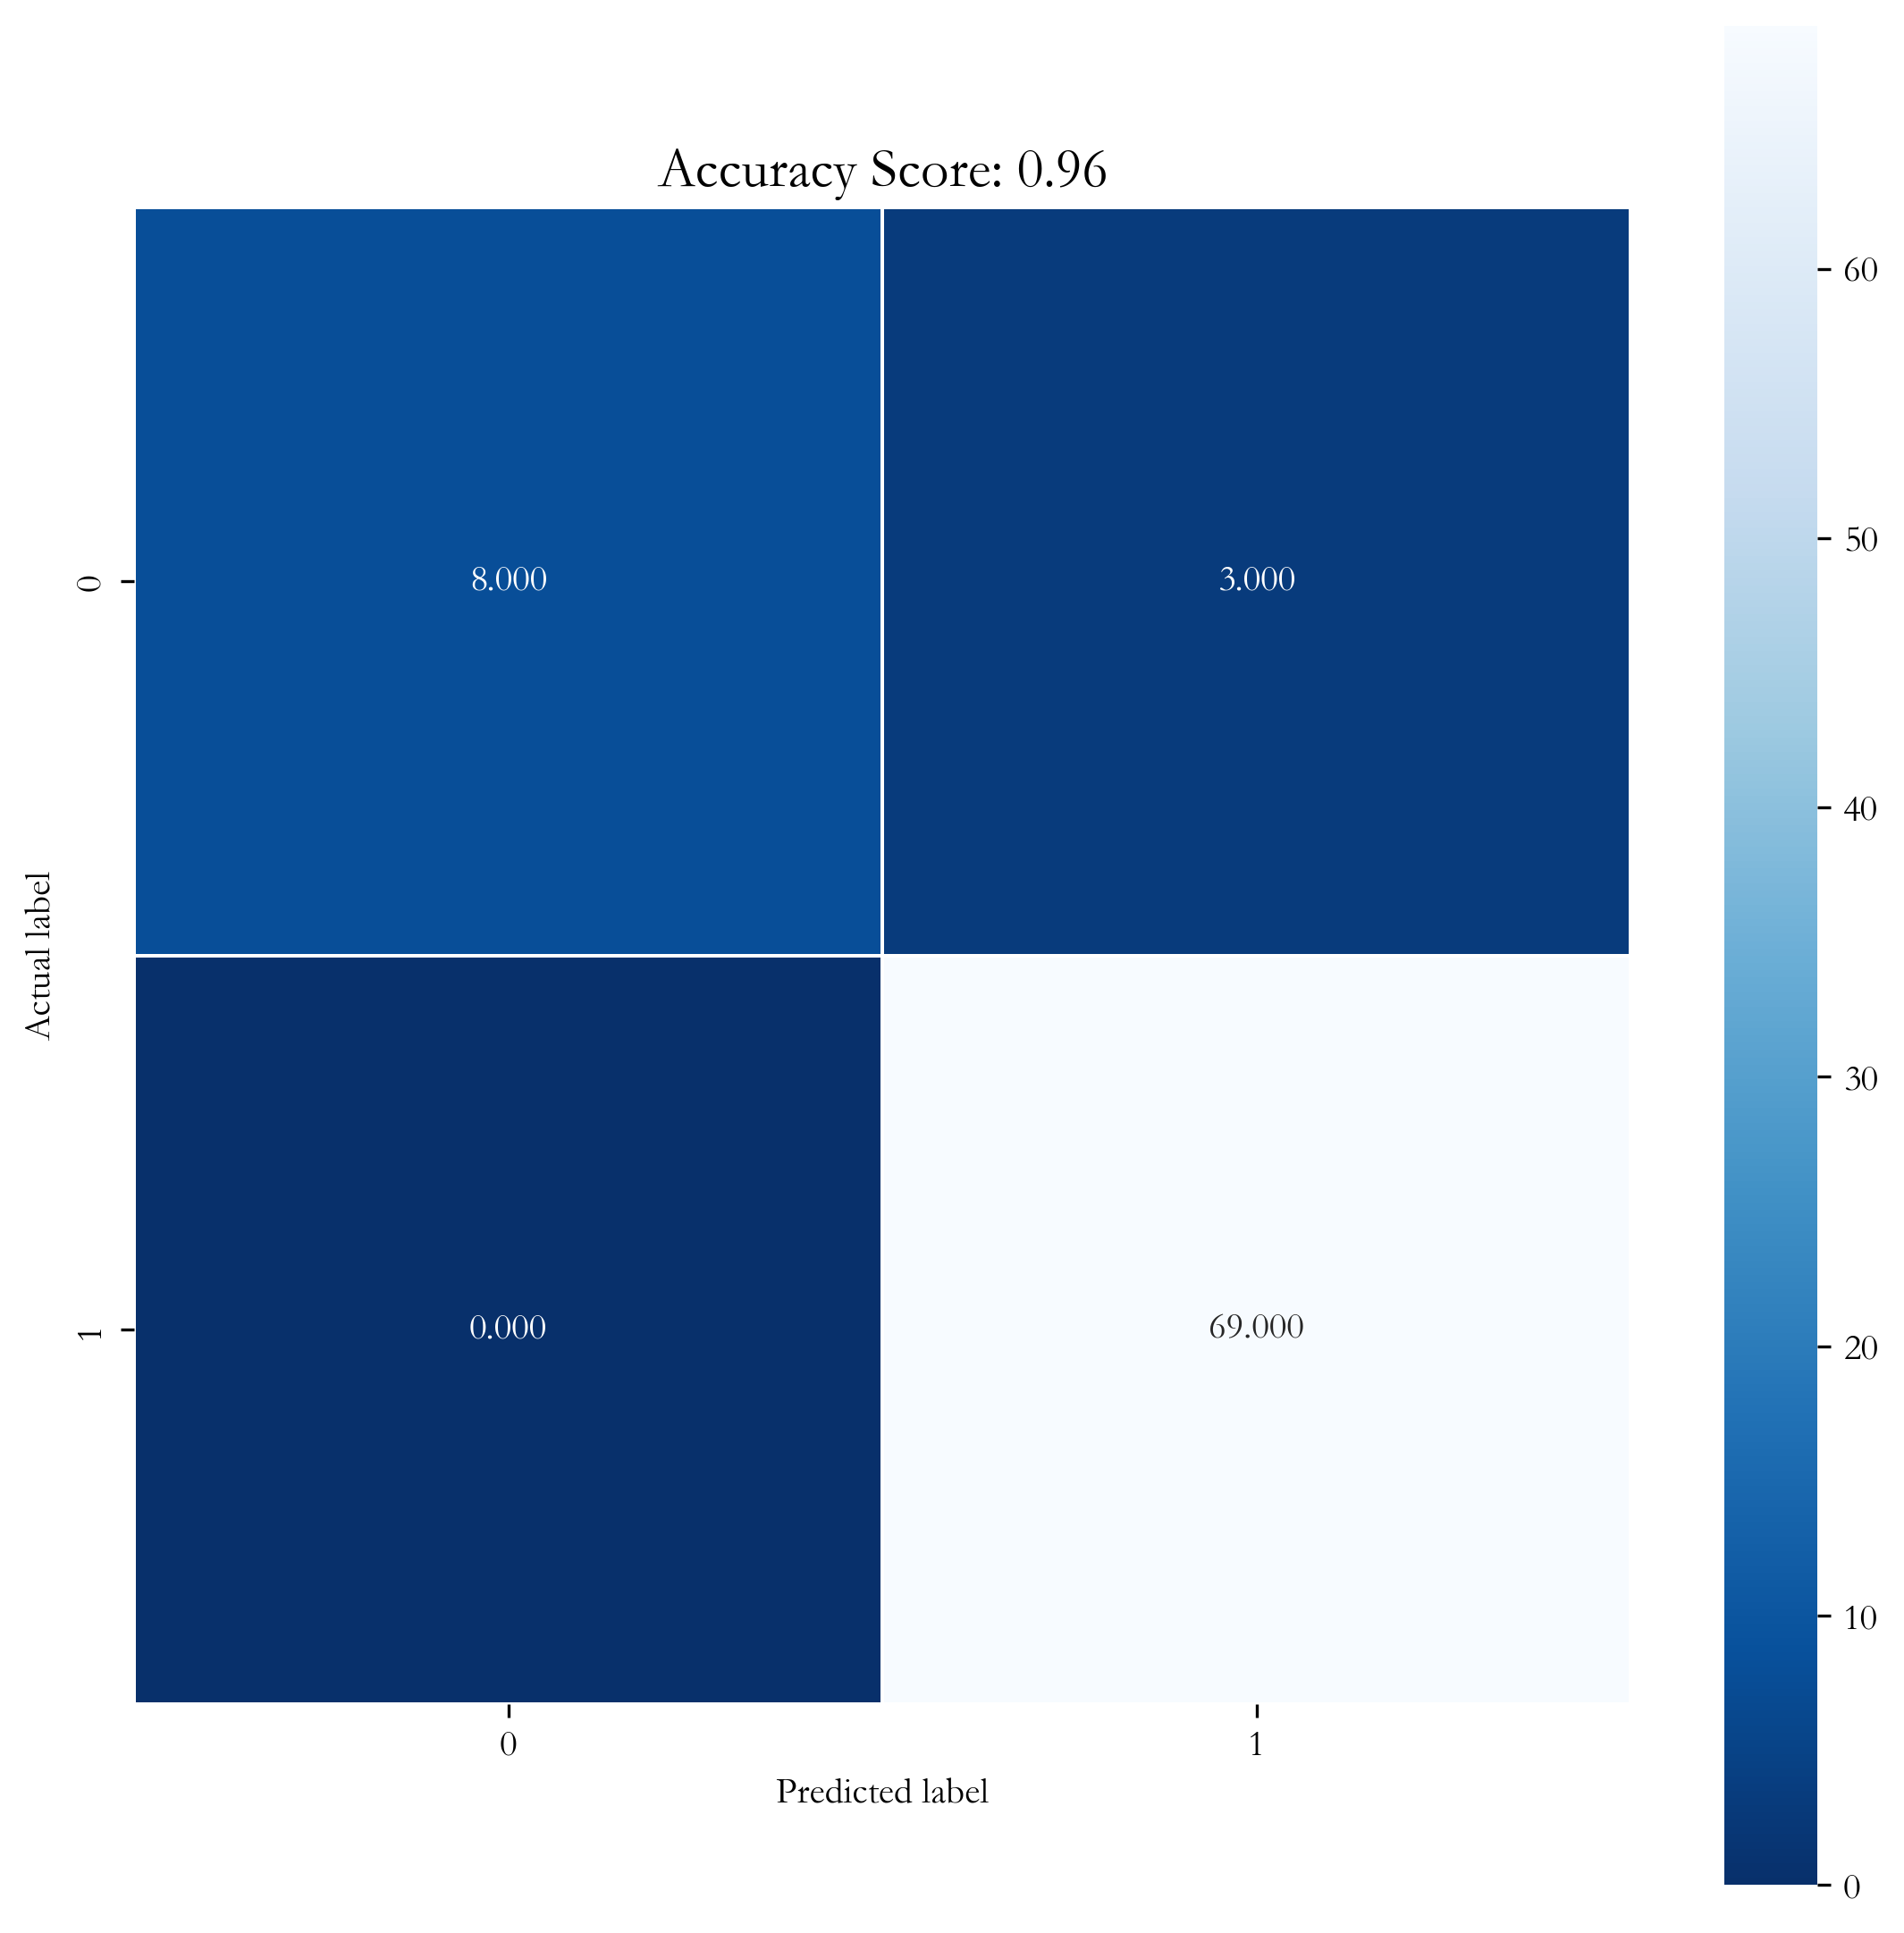

In [22]:
from utils.Display_Plot import plot_confusion_matrix

plot_confusion_matrix(y_test, y_pred, accuracy=test_accuracy, 
                      is_save=False, save_path="BB")

(To LXY):混淆矩阵，这些评估用的图不要改中文，都是术语翻译会丢失原始含义，简单描述一下图就行了

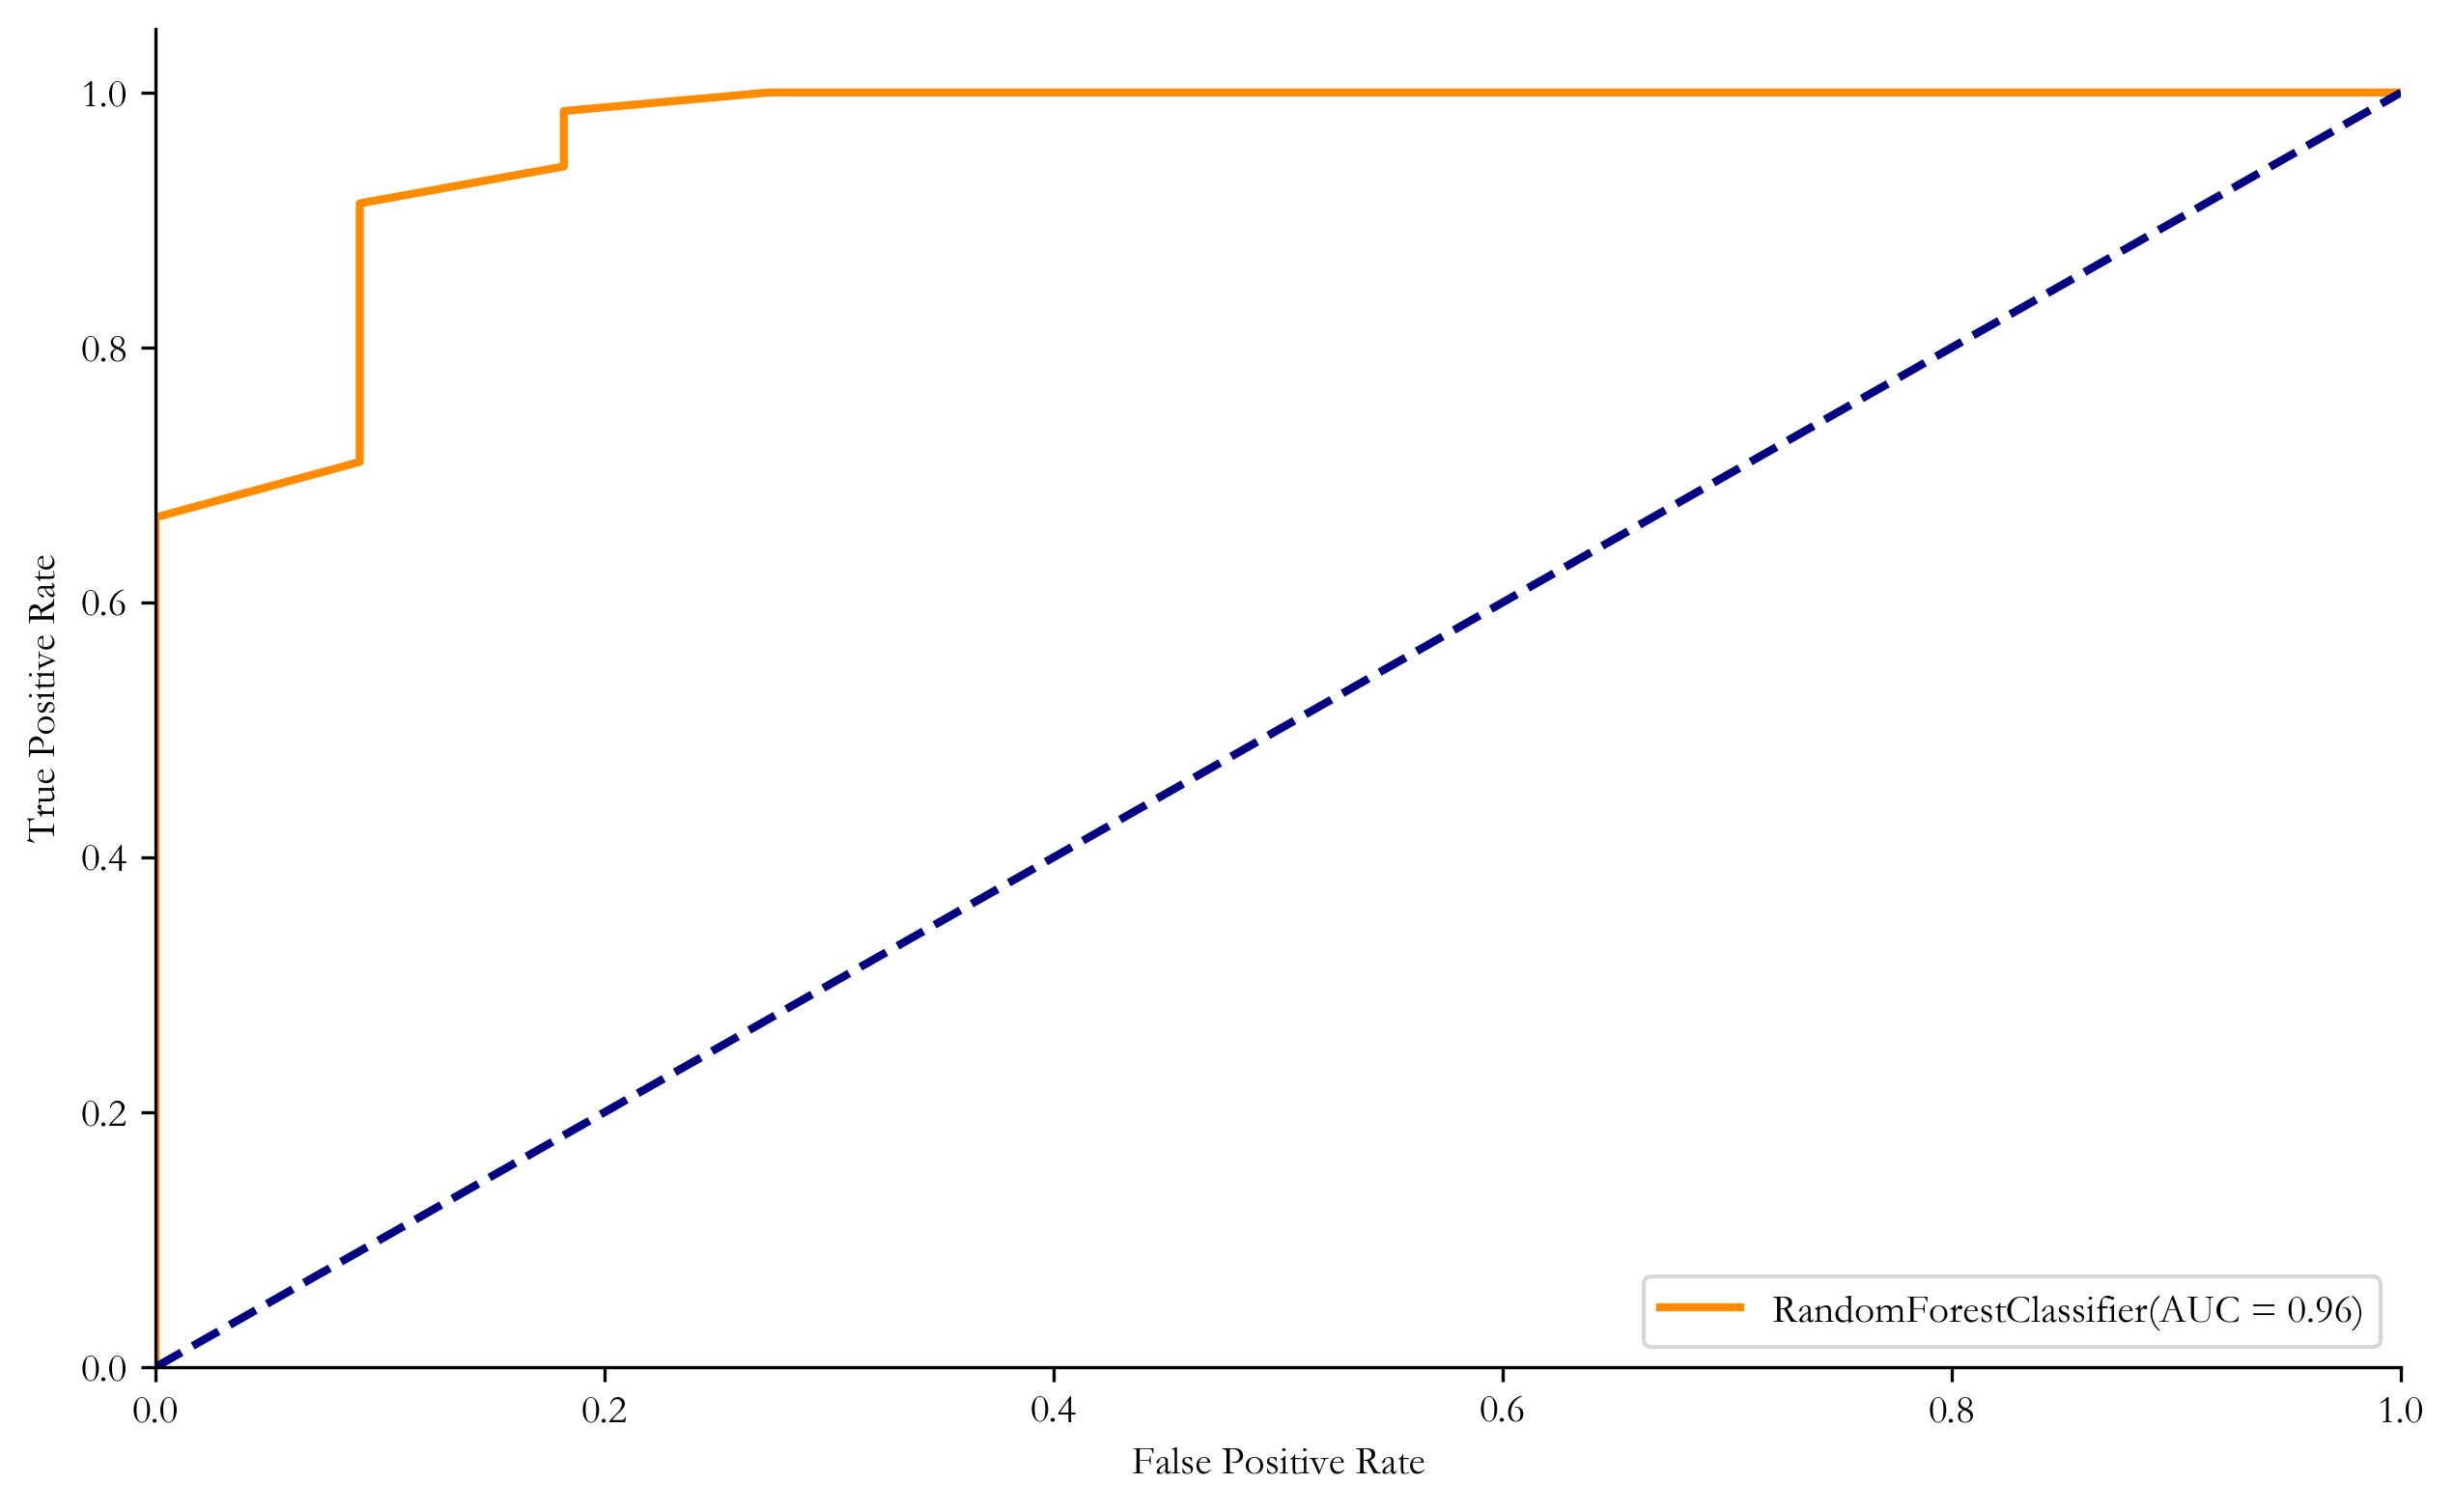

In [23]:
from utils.Display_Plot import plot_roc_curve

plot_roc_curve(y_test, y_pred_prob[::,1], "RandomForestClassifier", 
               is_save=False, save_path="ccf")

(To LXY):AUC是曲线下的面积，越大越好，简单描述一下图就行了

(To LXY):到这里，我们不难发现，随机森林的结果比决策树好，说明模型训练的很好，然后模型里面的那些参数是具有一定解释意义的，就按照那些参数来描述我们的结果，比如说。哪些东西对客户的持续购买意愿影响比较大？哪些有助于帮助我们辨别出客户具有持续购买意愿就好

### 5.Amos Graghics

从选择关键变量开始，然后进行初步的探索性数据分析（EDA）。让我们首先关注一些核心变量，比如性别、年龄、职业、学历、月收入、消费频率和购买渠道，然后检查这些变量与消费者对新中式茶饮看法之间的关系。

In [56]:
column_names = raw_data.columns
column_names

Index(['1、您的性别：', '2、您的年级', '3、在校期间，您的月消费一般为：',
       '4、您一个月喝茶饮的频率是？', '5、您习惯的茶饮购买渠道是？',
       '6、平常生活中，您习惯于从以下哪种渠道中获取的信息？',
       '7、您希望以哪种形式享用茶饮？',
       '8、以下茶饮分类中，目前您更偏向于喝哪种？',
       '9、您更喜欢哪种口味的茶饮？', '10、您对茶饮的甜度偏好是？',
       '11、您喜欢的包装风格是', '12、您最喜欢的茶饮促销方式是？',
       '13、您能接受的一杯新中式茶饮的最高价格是？',
       '14、您喝过新中式茶饮吗？', '15、您对新中式茶饮的认知程度是—价格区间',
       '15、健康养生程度', '15、包装风格', '15、产品类型', '15、围炉煮茶',
       '19、产品质量—口味口感', '19、用料品质', '19、原料健康程度',
       '19、特色度', '20、附属产品—包装精美', '20、容器质量', '20、赠品迷人',
       '21、价格因素—价格合理', '21、促销力度', '21、性价比高',
       '22、服务—店员服务态度', '22、平台服务', '22、产品介绍和推荐',
       '22、点单指导', '22、门店环境', '23、消费者自身偏好—养生重视度',
       '23、国潮喜爱程度', '23、茶文化认同感', '23、茶饮名称好听',
       '23、围炉煮茶氛围感', '24、营销推广度—联名/周边', '24、茶饮品牌知名度',
       '24、产品曝光度', '24、顾客认可度',
       '25、购买意愿—我计划不久后购买新中式茶饮',
       '25、以后我会持续购买新中式茶饮', '25、我愿意尝试更多种类的新中式茶饮',
       '26、您认为新中式茶饮未来前景如何？'],
      dtype='object')

In [57]:
corrected_variables_for_eda = {
    '性别': '1、您的性别：',
    '年级': '2、您的年级',
    '月消费': '3、在校期间，您的月消费一般为：',
    '消费频率': '4、您一个月喝茶饮的频率是？',
    '购买渠道': '5、您习惯的茶饮购买渠道是？'
}

eda_summary_corrected = raw_data[list(corrected_variables_for_eda.values())].describe(include='all')

eda_summary_corrected


,1、您的性别：,2、您的年级,3、在校期间，您的月消费一般为：,4、您一个月喝茶饮的频率是？,5、您习惯的茶饮购买渠道是？
count,666,666,666,666,666
unique,2,7,6,5,4
top,女,专科,1001~1500元,经常，几乎每周都喝，一个月5~10次,外卖平台下单
freq,376,162,184,220,285


从初步的探索性数据分析（EDA）中，我们可以观察到以下关键点（这里改一下）：

- 性别：参与者中男性（53人）略多于女性。
- 年龄：大多数参与者（43人）处于18~25岁年龄段。
- 职业：普通职员是最常见的职业（56人）。
- 学历：大专学历的参与者最多（43人）。
- 月收入：5001~10000元是最常见的月收入区间（45人）。
- 消费频率：绝大多数参与者表示“经常，几乎每周都喝，一个月5~10次”（55人）。
- 购买渠道：门店购买是最习惯的购买渠道（44人）。

这些信息为我们提供了一个关于新中式茶饮消费者特征的概览。年轻的、普通职员、有一定教育背景和中等收入水平的人群似乎是新中式茶饮的主要消费者。他们倾向于频繁消费，并且更喜欢在门店购买。

接下来，我们可以基于这些信息，进一步探索哪些因素影响消费者对新中式茶饮的看法，例如通过查看消费频率与其他变量之间的关系，或者分析不同年龄段和收入水平的消费者对茶饮的偏好差异。我们可以使用相关性分析或构建一些简单的预测模型来探索这些变量之间的关系。

In [62]:
gender_mapping = {'男': 1, '女': 0}
income_mapping = {income: index for index, income in enumerate(raw_data['3、在校期间，您的月消费一般为：'].unique())}
frequency_mapping = {frequency: index for index, frequency in enumerate(raw_data['4、您一个月喝茶饮的频率是？'].unique())}
channel_mapping = {channel: index for index, channel in enumerate(raw_data['5、您习惯的茶饮购买渠道是？'].unique())}

# Applying mappings
raw_data_mapped = raw_data.copy()
raw_data_mapped['您的性别：'] = raw_data['1、您的性别：'].map(gender_mapping)
raw_data_mapped['您的月收入：'] = raw_data['3、在校期间，您的月消费一般为：'].map(income_mapping)
raw_data_mapped['您一个月喝茶饮的频率是？'] = raw_data['4、您一个月喝茶饮的频率是？'].map(frequency_mapping)
raw_data_mapped['您习惯的茶饮购买渠道是？'] = raw_data['5、您习惯的茶饮购买渠道是？'].map(channel_mapping)

Ya_raw_data = pd.get_dummies(raw_data_mapped, drop_first=True, dtype=int)

correlation_with_frequency = Ya_raw_data.corrwith(Ya_raw_data['您一个月喝茶饮的频率是？'])
correlation_with_frequency

15、您对新中式茶饮的认知程度是—价格区间                                                                        0.029403
15、健康养生程度                                                                                                0.002749
15、包装风格                                                                                                   -0.006618
15、产品类型                                                                                                   -0.031552
15、围炉煮茶                                                                                                    0.021646
19、产品质量—口味口感                                                                                          0.042158
19、用料品质                                                                                                   -0.003256
19、原料健康程度                                                                                                0.038705
19、特色度                                                                                         

根据相关性分析的结果，我们可以看到各因素与消费频率之间的相关性大小如下：

- 您的性别：-0.081746，性别与消费频率之间存在轻微的负相关性，这表明男性消费者与茶饮消费频率之间可能有轻微的负向关联，即男性消费者的茶饮消费频率略低于女性。
- 您的月收入：-0.031695，月收入与消费频率之间的负相关性较弱，暗示不同收入水平的消费者在茶饮消费频率上的差异不明显，收入对消费频率的影响力有限。
- 您习惯的茶饮购买渠道是？：0.035239，购买渠道与消费频率之间的相关性较弱，但为正相关，这可能反映出消费者对于购买渠道的偏好轻微影响着他们的消费频率。不同的购买渠道（如门店购买、在线购买等）可能对消费频率有轻微的促进作用。

这些结果揭示了消费者的茶饮消费行为与性别、月收入和购买渠道之间的关系。尽管性别和月收入的影响较为有限，但它们仍对消费频率有着轻微的影响。购买渠道的正相关性提示我们，消费者的购买偏好可能会对他们的消费频率产生影响，尽管这种影响不大。
综上所述，虽然性别、月收入和购买渠道对消费频率的直接影响有限，但这些因素仍然是理解和预测消费者茶饮消费行为的重要组成部分。这些见解对于茶饮市场的营销策略和产品定位具有一定的参考价值，特别是在考虑如何通过不同的营销渠道接触不同性别和收入水平的消费者时。


In [64]:
# 分析受访者最常用的茶饮购买渠道
channel_counts = raw_data['5、您习惯的茶饮购买渠道是？'].value_counts()
channel_counts


5、您习惯的茶饮购买渠道是？
外卖平台下单          285
品牌专门小程序购买    171
门店购买              137
其他                   73
Name: count, dtype: int64

受访者最常用的茶饮购买渠道是「门店购买」和「外卖app下单」，这两个渠道的使用人数非常接近，分别为44人和43人。此外，「小程序购买」也有一定的使用者，共11人。还有3人选择了「其他」作为他们的购买渠道。

这表明虽然线上购买方式（如外卖app和小程序）在现代消费中变得越来越流行，但传统的门店购买方式仍然保持着重要的地位。这可能反映了消费者在购买茶饮时既追求便利性也重视体验感。

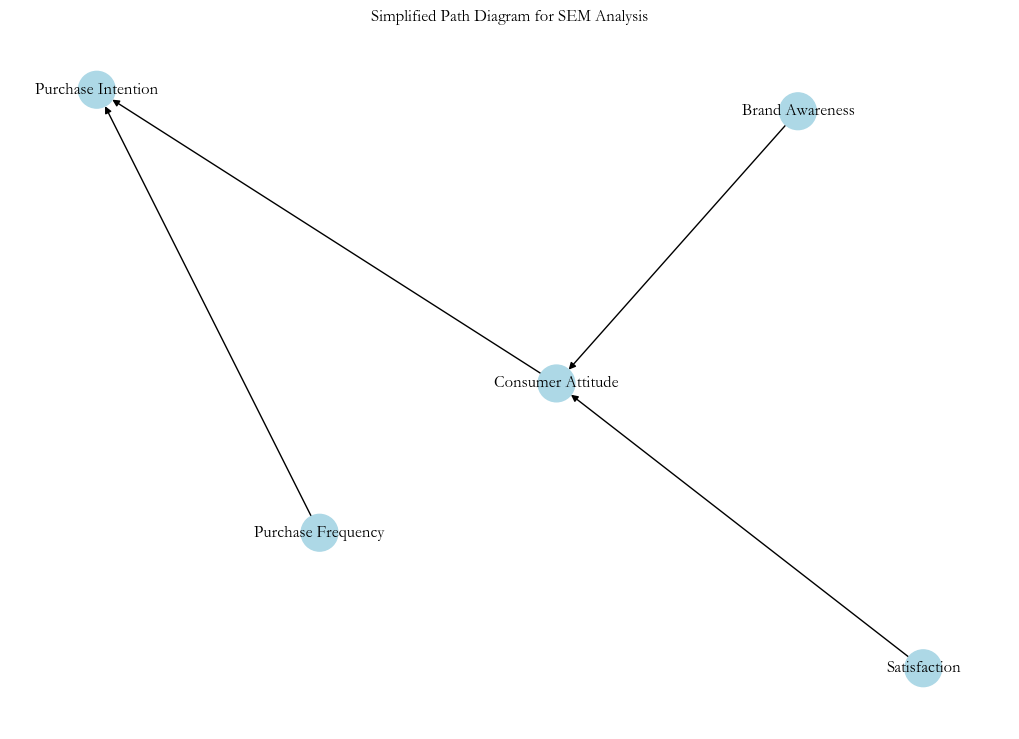

In [67]:

# 创建一个有向图
G = nx.DiGraph()

# 添加节点
G.add_node("Consumer Attitude", node_color='lightblue')
G.add_node("Purchase Intention", node_color='lightgreen')
G.add_node("Brand Awareness", node_color='lightcoral')
G.add_node("Satisfaction", node_color='lightgrey')
G.add_node("Purchase Frequency", node_color='lightgrey')

# 添加边来表示变量之间的关系
G.add_edges_from([
    ("Consumer Attitude", "Purchase Intention"),
    ("Brand Awareness", "Consumer Attitude"),
    ("Satisfaction", "Consumer Attitude"),
    ("Purchase Frequency", "Purchase Intention")
])

# 图形布局
pos = nx.spring_layout(G)

# 节点大小
sizes = [700 for _ in range(len(G.nodes()))]

# 绘制图形
plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_size=sizes, node_color="lightblue", font_size=12, arrows=True)

# 显示图形
plt.title("Simplified Path Diagram for SEM Analysis")
plt.show()


根据这个图形的结果可以发现
- 「消费者态度」受到「品牌认知」和「满意度」的影响
- 「购买意愿」则受到「消费者态度」和「购买频率」的影响